**Libraries Needed**  
numpy
jieba
gensim
tensorflow
matplotlib
sklearn

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

**Pretrained Word Vectors**  
使用了北京师范大学中文信息处理研究所与中国人民大学 DBIIR 实验室的研究者开源的Chinese-Word-Vectors：  
https://github.com/Embedding/Chinese-Word-Vectors  
word2vec的文章：  
https://zhuanlan.zhihu.com/p/26306795  
我们使用了"chinese-word-vectors"知乎Word+Ngram的词向量，可以从上面github链接下载。

In [2]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('../../sgns.zhihu.bigram',binary=False)

**Word Vectors Model**  
在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量。LSTM并不能直接处理汉字文本，需要先进行分次并把词汇转换为词向量。

In [3]:
# 每一个词都对应一个长度为300的向量
embedding_dim = cn_model['孔子'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
# cn_model['孔子']

词向量的长度为300


In [4]:
# 计算相似度
cn_model.similarity('孔子', '庄子')

0.521646

In [5]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['中国'], topn=10)

[('我国', 0.6130719184875488),
 ('天朝', 0.5357025861740112),
 ('美国', 0.5048182010650635),
 ('中国人', 0.5000995993614197),
 ('本国', 0.4976556897163391),
 ('印度', 0.49548032879829407),
 ('日本', 0.491807758808136),
 ('国内', 0.4640890955924988),
 ('大陆', 0.4627026915550232),
 ('中华民族', 0.43461209535598755)]

In [6]:
# 找出不同的词
test_words = '孔丘 圣人 孔子 孟子 孔子 荀子'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 孔丘 圣人 孔子 孟子 孔子 荀子 中:
不是同一类别的词为: 圣人


In [7]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=1)

[('劈腿', 0.5849199295043945)]

In [8]:
# 样本存放于两个文件夹中，分别为正面评价文件夹'pos'和负面评价文件夹'neg'
# 每个文件夹中有txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('Mental or Casual/mental')
neg_txts = os.listdir('Mental or Casual/casual')

In [9]:
print('样本总共: '+ str(len(pos_txts) + len(neg_txts)))

样本总共: 106757


In [12]:
# 现在我们将所有的评价内容放置到一个list里
train_texts_orig = []
for i in range(len(pos_txts)):
    with open('Mental or Casual/mental/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('Mental or Casual/casual/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
# 添加完所有样本之后，train_texts_orig为一个含有文本的list，其中先是正面评价，后为负面评价

In [13]:
# Verify integrity of original data
len(train_texts_orig)
train_texts_orig[0]

'每天都有干不完的事情'

In [14]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

**分词和tokenize**  
首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [15]:
# 进行分词和tokenize
# train_tokens是一个长list，其中含有多个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\EdiC\AppData\Local\Temp\jieba.cache
Loading model cost 1.208 seconds.
Prefix dict has been built succesfully.


**索引长度标准化**  
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [16]:
# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens]
num_tokens = np.array(num_tokens)

In [17]:
# 平均tokens的长度
np.mean(num_tokens)

6.921410305647405

In [18]:
# 最长的评价tokens的长度
np.max(num_tokens)
print(num_tokens)

[ 8  2  9 ...  9  3 11]


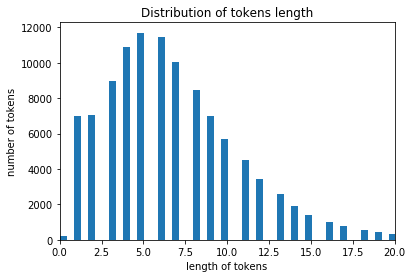

In [22]:
plt.hist(num_tokens,bins=1000)
plt.xlim((0,20))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [23]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

16

In [24]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9581854117294416

**反向tokenize**  
我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [25]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [29]:
reverse = reverse_tokens(train_tokens[10])

In [30]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'就会产生浓浓的偷窥欲'

In [32]:
# 原始文本
train_texts_orig[10]

'就会产生浓浓的偷窥欲'

**准备Embedding Matrix**  
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。  
注意我们只选择使用前100k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [33]:
embedding_dim

300

In [34]:
# 只使用前100000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 100000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [35]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [36]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(100000, 300)

**padding（填充）和truncating（修剪）**  
我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [37]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [38]:
# 超出五万个词向量的词用0代替
train_pad[train_pad>=num_words] = 0

In [39]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   316,  1818, 76451,   433, 27237, 13478])

In [40]:
# 准备target向量，前32477样本为1，后74280为0
train_target = np.concatenate((np.ones(32477),np.zeros(74280)))

In [41]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [42]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=6)

In [51]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[8]))
print('class: ',y_train[8])

         而我对于此事的悲观看法
class:  1.0


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。   
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$
输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [52]:
# 用LSTM对样本进行分类
model = Sequential()

# 模型第一层为Embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

Instructions for updating:
Colocations handled automatically by placer.


In [53]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

**构建模型**  
我在这个教程中尝试了几种神经网络结构，因为训练样本比较少，所以我们可以尽情尝试，训练过程等待时间并不长：  
**GRU：**如果使用GRU的话，测试样本可以达到87%的准确率，但我测试自己的文本内容时发现，GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。  
**BiLSTM：**测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆，有兴趣的朋友可以深入研究一下。  
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [54]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [55]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [57]:
# 模型的结构
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 64)            85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 30,090,449
Trainable params: 90,449
Non-trainable params: 30,000,000
_________________________________________________________________


In [58]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [65]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [59]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [60]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [61]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [62]:
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 86472 samples, validate on 9609 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
86400/86472 [============================>.] - ETA: 0s - loss: 0.3055 - acc: 0.8617
Epoch 00001: val_loss improved from inf to 0.26318, saving model to sentiment_checkpoint.keras
86472/86472 [==============================] - 61s 707us/sample - loss: 0.3054 - acc: 0.8618 - val_loss: 0.2632 - val_acc: 0.8805
Epoch 2/20
86400/86472 [============================>.] - ETA: 0s - loss: 0.2468 - acc: 0.8882
Epoch 00002: val_loss improved from 0.26318 to 0.25197, saving model to sentiment_checkpoint.keras
86472/86472 [==============================] - 61s 701us/sample - loss: 0.2469 - acc: 0.8882 - val_loss: 0.2520 - val_acc: 0.8860
Epoch 3/20
86400/86472 [============================>.] - ETA: 0s - loss: 0.2279 - acc: 0.8975
Epoch 00003: val_loss improved from 0.25197 to 0.25036, saving model to sentiment_checkpoint.keras
86472/86472 [==============================] - 55s 635us/sample -

**结论**  
我们首先对测试样本进行预测，得到了还算满意的准确度。  
之后我们定义一个预测函数，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [63]:
result = model.evaluate(X_test, y_test)
print('Accuracy:'+str(result[1]))

10676/10676 [==============================] - 5s 433us/sample - loss: 0.2406 - acc: 0.9015
Accuracy:0.90146124


In [64]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是心理相关的','output=%.2f'%coef)
    else:
        print('是相对闲聊的','output=%.2f'%coef)

In [110]:
test_list = [
    '再接再厉，相同行为背后的原因是不一样的，再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的',
    '你好',
    '我们访问了海南',
    '我的心情有时候好，有时候不好',
    '我很孤独',
    '作者：几个高中生',
    '相同行为背后的原因是不一样的',
    '这真是个笑话',
    '我的人生就是个笑话',
    '同学你好'
]
for text in test_list:
    predict_sentiment(text)

再接再厉，相同行为背后的原因是不一样的，再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的再接再厉，相同行为背后的原因是不一样的
是心理相关的 output=0.96
你好
是心理相关的 output=0.99
我们访问了海南
是相对闲聊的 output=0.04
我的心情有时候好，有时候不好
是心理相关的 output=0.93
我很孤独
是心理相关的 output=0.90
作者：几个高中生
是相对闲聊的 output=0.01
相同行为背后的原因是不一样的
是心理相关的 output=0.98
这真是个笑话
是相对闲聊的 output=0.15
我的人生就是个笑话
是相对闲聊的 output=0.43
同学你好
是心理相关的 output=1.00


##### **错误分类的文本**
经过查看，发现错误分类的文本的含义大多比较含糊，就算人类也不容易判断极性。

In [66]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [67]:
y_actual = np.array(y_test)

In [68]:
# 找出错误分类的索引
misclassified = np.where(y_pred != y_actual)[0]

In [105]:
# 输出所有错误分类的索引
print(len(misclassified))
print(len(X_test))

1052
10676


In [88]:
# 找出错误分类的样本
idx=1034
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

        我不希望它发生在任何人身上
预测的分类 1
实际的分类 0.0


In [100]:
idx=29
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

           简言之就是很多 上
预测的分类 0
实际的分类 1.0
